in this notebook we:
* train stage1 for rescaled images
* try to fix the exporting recurrsion error

In [1]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import neptune
from neptunecontrib.monitoring.fastai import NeptuneMonitor

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions import *

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
# PATH_TO_IMG = Path("/data_rescaled")

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [4]:
# ! pip install neptune-client neptune-contrib

In [5]:
neptune.init(project_qualified_name='appsilon/gabon-wildlife', 
            api_token=CONFIG["neptune"]["NEPTUNE_API_TOKEN"])

Project(appsilon/gabon-wildlife)

In [6]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [7]:
len(df.uniqueName)

347120

In [8]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [9]:
df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,resc_0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,resc_0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,resc_0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,resc_0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,resc_0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [10]:
%%time
data = get_training_data(df, (384 // 4, 512 // 4)) #, partial_pct=0.01)

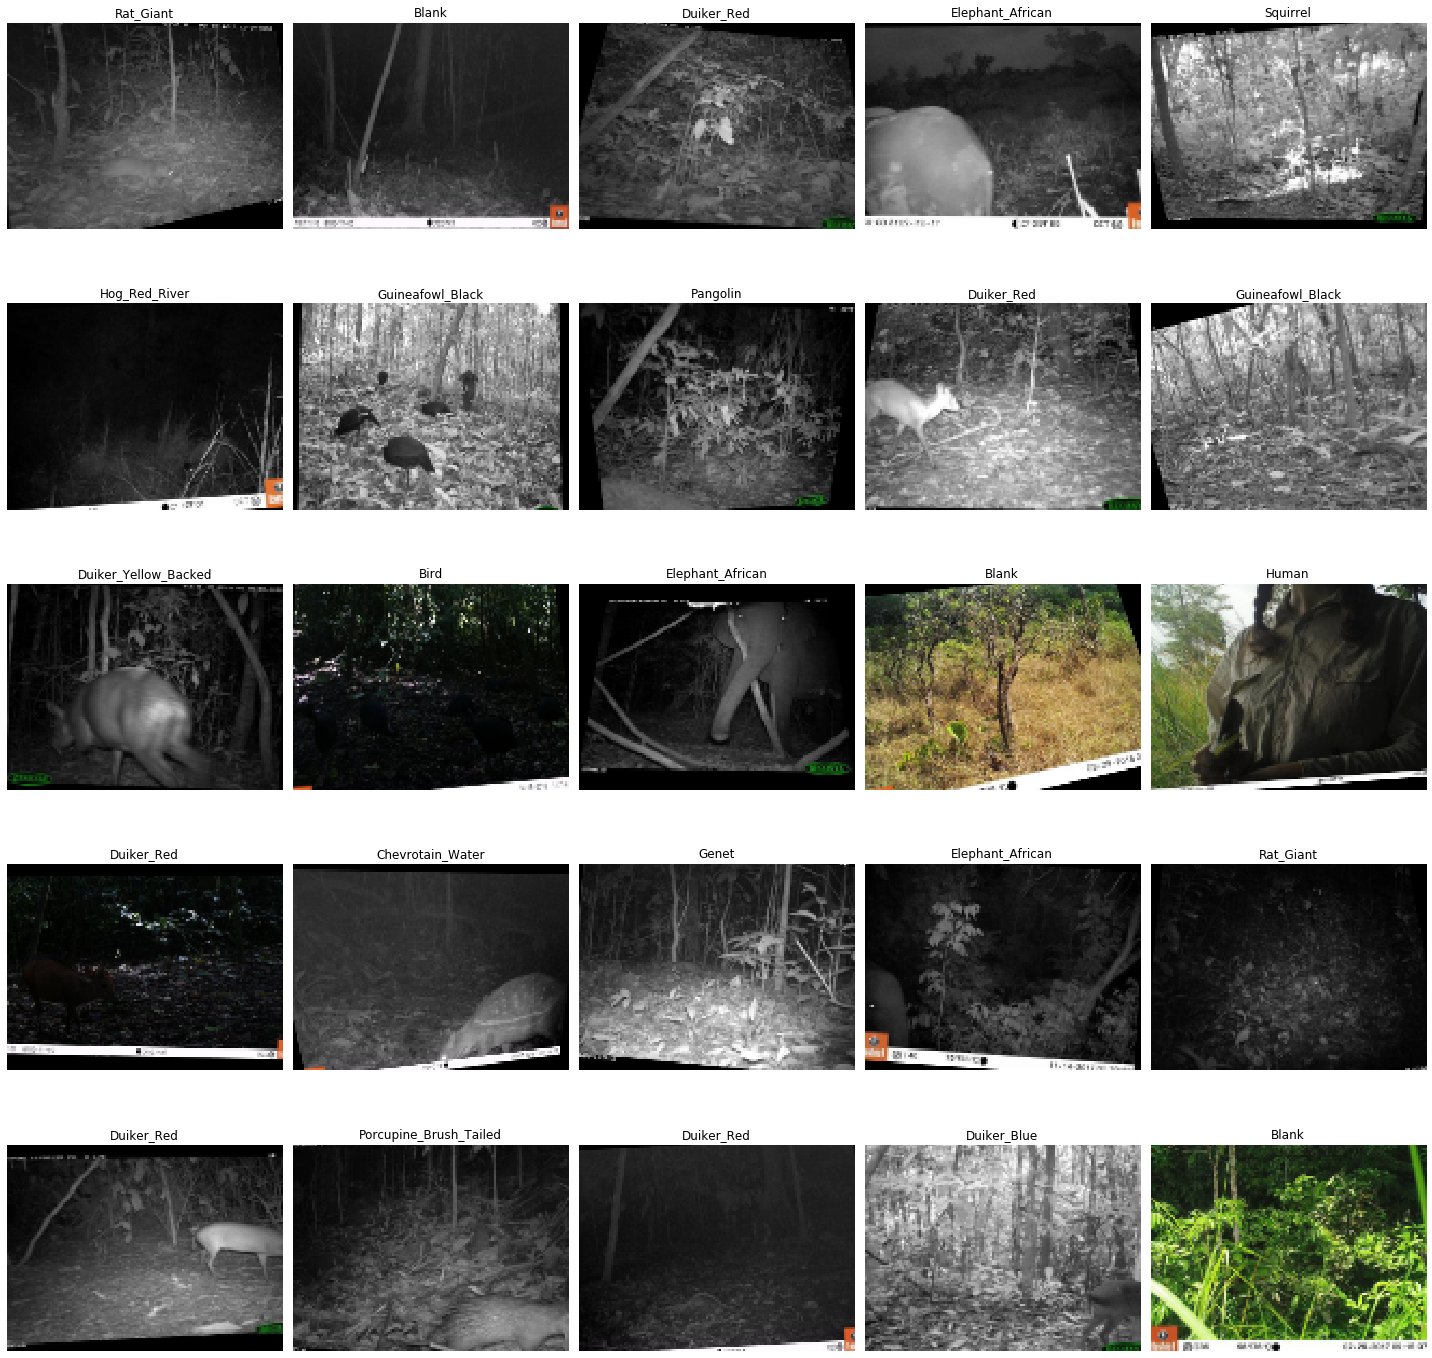

In [11]:
%%time
data.show_batch()

# Stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 21.3 s, sys: 9.05 s, total: 30.4 s
Wall time: 7min 50s


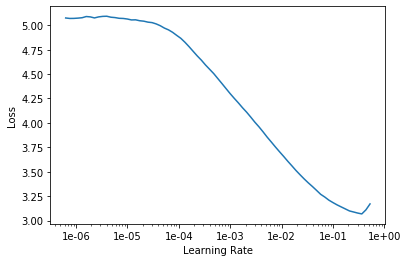

In [12]:
%%time
learn = get_initial_learner(data)
run_find_lr(learn, "stage1-1epochs-96_128-rescaled")

In [15]:
initial_lr = 1e-2 / 2

In [ ]:
%%time
learn = get_initial_learner(data)

with neptune.create_experiment(params = {"initial_lr": initial_lr}): 
    learn.callbacks.append(NeptuneMonitor())
    run_training(learn, "stage1-1epochs-96_128-rescaled", lr=initial_lr, n_epochs=2)

https://ui.neptune.ai/appsilon/gabon-wildlife/e/GAB-5


INFO:root:running training stage1-1epochs-96_128-rescaled


epoch,train_loss,valid_loss,accuracy,time


# Export learner (fixing issue with )

# Stage 2

#### Load learner

In [10]:
learn = get_initial_learner(data)
learn = learn.load(PATH_TO_MODELS / "stage1-1epochs-96_128-01_full_data")

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 10 s, sys: 2.54 s, total: 12.5 s
Wall time: 8min 17s


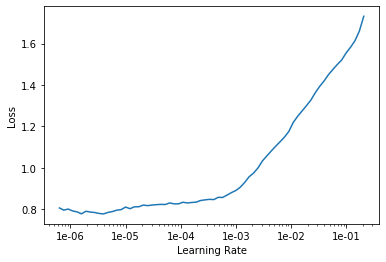

In [28]:
# %%time
# run_find_lr(learn, "stage2-5epochs-96_128-01_full_data")

In [12]:
initial_lr = 0.01
lr = 1e-6
lr_end = initial_lr / 10
n_epochs =  5

In [13]:
with neptune.create_experiment(params = {
                                        "initial_lr": initial_lr,
                                        "lr": lr,
                                        "lr_end": lr_end,
                                        "n_epochs": n_epochs
                                        }): 
    learn.callbacks.append(NeptuneMonitor())

    run_training(learn, "stage2-5epochs-96_128-01_full_data", lr=lr, lr_end=lr_end, n_epochs=n_epochs)

https://ui.neptune.ai/appsilon/gabon-wildlife/e/GAB-3


INFO:root:running training stage2-5epochs-96_128-01_full_data


epoch,train_loss,valid_loss,accuracy,time
0,0.687381,1.608814,0.546140,4:18:19
1,0.561375,1.807278,0.540387,4:18:25
2,0.427339,1.781848,0.561428,4:20:44
3,0.351815,1.875070,0.565898,4:20:40
4,0.330786,1.873039,0.567686,4:18:14


INFO:root:finished training stage2-5epochs-96_128-01_full_data


RecursionError: maximum recursion depth exceeded

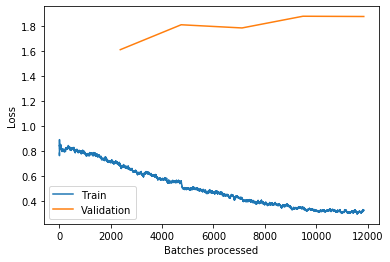

In [15]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
3+4

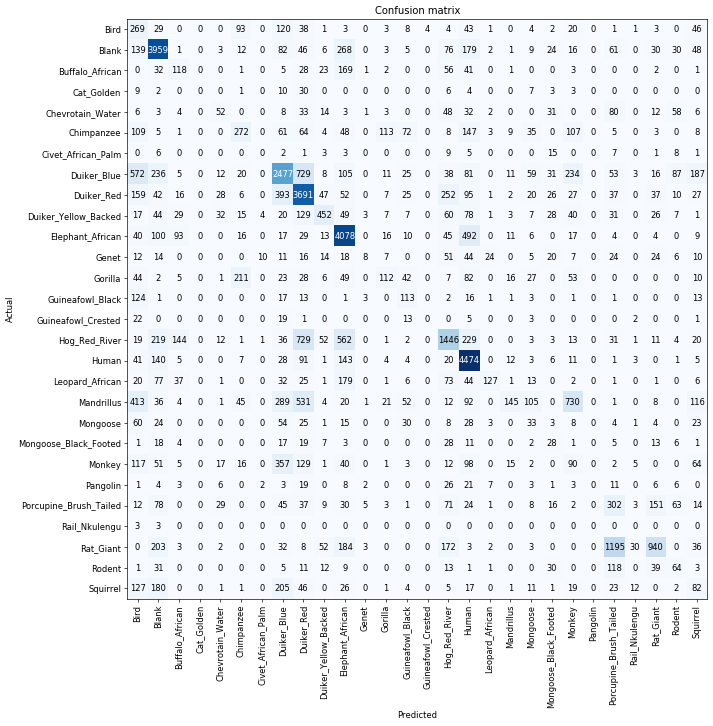

In [35]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)